2750


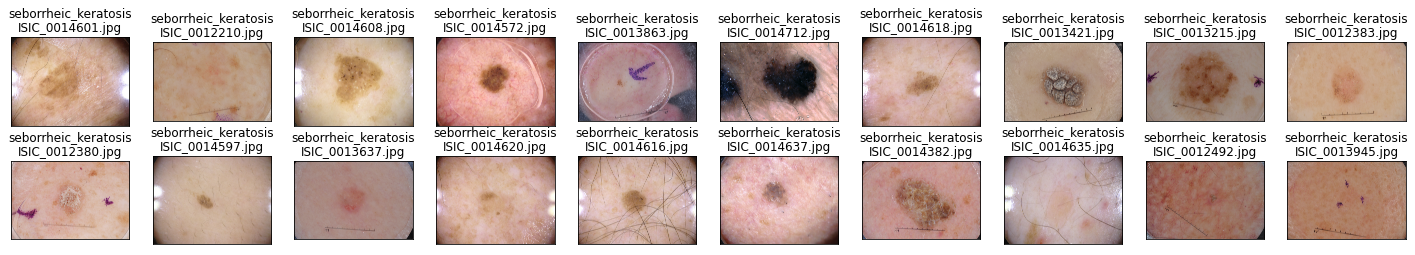

In [13]:
# visualize data

import matplotlib.pyplot as plt                        
%matplotlib inline
import numpy as np
from glob import glob
from PIL import Image
# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torchvision.transforms as transforms

data_files = np.array(glob("data/*/*/*"))

print(f'data size {data_files.shape[0]}')

fig = plt.figure(figsize=(25, 4))
i = 0
for img_path in data_files[:20]:
    i += 1
    ax = fig.add_subplot(2, 10, i, xticks=[], yticks=[])
    image = Image.open(img_path)
    image = transforms.Compose([transforms.ToTensor()])(image)
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    ax.set_title("{}\n{}".format(img_path.split('/')[-2], img_path.split('/')[-1]))

In [15]:
# data loader
import os
from torchvision import datasets
import torch

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
data_dir = 'data/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')
valid_dir = os.path.join(data_dir, 'valid/')

batch_sizes = 64
transforms1 = transforms.Compose([transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(20),
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

transforms2 = transforms.Compose([transforms.Resize(256),
                                  transforms.CenterCrop(224), 
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(train_dir, transform=transforms1)
test_data = datasets.ImageFolder(test_dir, transform=transforms2)
valid_data = datasets.ImageFolder(valid_dir, transform=transforms2)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num valid images: ', len(valid_data))
print('Num test images: ', len(test_data))
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sizes, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_sizes, 
                                          num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_sizes, 
                                          num_workers=num_workers, shuffle=False)

Num training images:  2000
Num valid images:  150
Num test images:  600


In [24]:
# pretrained models
import torchvision.models as models
import torch.nn as nn

resnet = models.resnet50(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False

n_inputs = resnet.fc.in_features
last_layer = nn.Linear(n_inputs, 3)

resnet.fc = last_layer

# check if CUDA is available
use_cuda = torch.cuda.is_available()

if use_cuda:
    resnet = resnet.cuda()

print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [43]:
# check linear layer parameters
for name, param in resnet.named_parameters():
    if param.requires_grad:
        print(f'{name}, {param.data}, {param.requires_grad}')

fc.weight, tensor([[-0.0097,  0.0183, -0.0120,  ..., -0.0118, -0.0168,  0.0058],
        [ 0.0083,  0.0149,  0.0123,  ..., -0.0129, -0.0008, -0.0103],
        [ 0.0051, -0.0023, -0.0018,  ..., -0.0180,  0.0157, -0.0014]]), True
fc.bias, tensor([-0.0060, -0.0214, -0.0147]), True


In [44]:
import torch.optim as optim

### TODO: select loss function
criterion = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

In [77]:
# training method
import time

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    train_loss_values = []
    valid_loss_values = []

    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        start = time.time()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU

            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            #print(f'\rbatch {batch_idx} train_loss {train_loss:.6f}', end='')
        train_loss_values.append(train_loss)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            #print(f'\rbatch {batch_idx} valid_loss {valid_loss:.6f}', end='')
        valid_loss_values.append(valid_loss)

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTime elapse: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss,
            time.time()-start
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    # plot losses
    plt.plot(np.arange(1, n_epochs+1), train_loss_values, 'b', label='train loss')
    plt.plot(np.arange(1, n_epochs+1), valid_loss_values, 'r', label='valid loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()

    # return trained model
    return model, train_loss_values, valid_loss_values


Epoch: 1 	Training Loss: 0.516677 	Validation Loss: 0.621756 	Time elapse: 465.665542
Validation loss decreased (inf --> 0.621756).  Saving model ...
Epoch: 2 	Training Loss: 0.536830 	Validation Loss: 0.686009 	Time elapse: 465.232296
Epoch: 3 	Training Loss: 0.523041 	Validation Loss: 0.660831 	Time elapse: 466.311332
Epoch: 4 	Training Loss: 0.523829 	Validation Loss: 0.681358 	Time elapse: 466.087557
Epoch: 5 	Training Loss: 0.526547 	Validation Loss: 0.640792 	Time elapse: 465.532056
Epoch: 6 	Training Loss: 0.519499 	Validation Loss: 0.741144 	Time elapse: 464.351010
Epoch: 7 	Training Loss: 0.527382 	Validation Loss: 0.647761 	Time elapse: 467.155766
Epoch: 8 	Training Loss: 0.536351 	Validation Loss: 0.574736 	Time elapse: 467.058188
Validation loss decreased (0.621756 --> 0.574736).  Saving model ...
Epoch: 9 	Training Loss: 0.514231 	Validation Loss: 0.640786 	Time elapse: 465.517922
Epoch: 10 	Training Loss: 0.521892 	Validation Loss: 0.648941 	Time elapse: 464.652613


<All keys matched successfully>

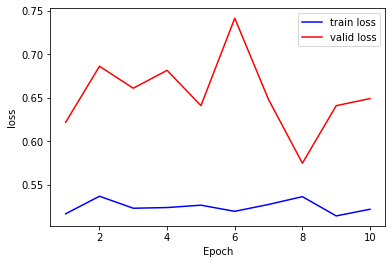

In [78]:
loaders = {'train':train_loader,
           'valid':valid_loader,
           'test':test_loader}

resnet, train_losses, valid_losses = train(10, loaders, resnet, optimizer, criterion, use_cuda, 'resnet_model.pt')

# load the model that got the best validation accuracy
resnet.load_state_dict(torch.load('resnet_model.pt'))

In [106]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    prediction = torch.empty(0)
    probability = torch.empty(0)
    probs = nn.Softmax(dim=1)
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        
        prediction = torch.cat((prediction, pred), dim = 0)
        probability = torch.cat((probability, probs(output)), dim = 0)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
    return probability, prediction

In [107]:
probability, prediction = test(loaders, resnet, criterion, use_cuda)

Test Loss: 0.709571


Test Accuracy: 67% (407/600)


In [181]:
if not os.path.isfile("output.csv"):
    f_output = open("output.csv", "a")
    f_output.write('Id,task_1,task_2\n')
    for file, prob, pred in zip(np.array(glob("data/test/*/*")), probability.detach().numpy(),prediction.numpy()):
        pred = int(pred.item())
        if pred == 0:
            f_output.write('{},{},{}\n'.format(file, prob[pred], 0))
        elif pred == 2:
            f_output.write('{},{},{}\n'.format(file, 0, prob[pred]))
        else:
            f_output.write('{},{},{}\n'.format(file, 0, 0))

    f_output.close()